In [2]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal

from aux import zscore
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

NRL_MDLS = ['lin', 'ln', 'dyn']
COLORS = ['b', 'm', 'k']
FPCAS = [
    f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_pca_nm91_zh23/pca_results.npy'
    for nrl_mdl in NRL_MDLS
]

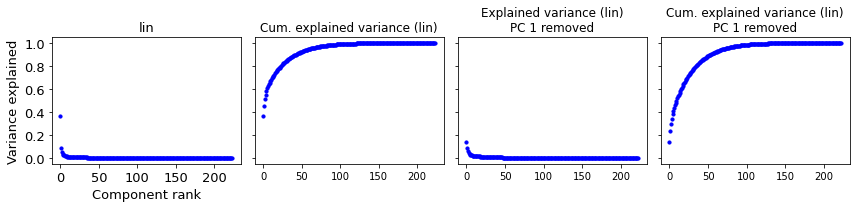

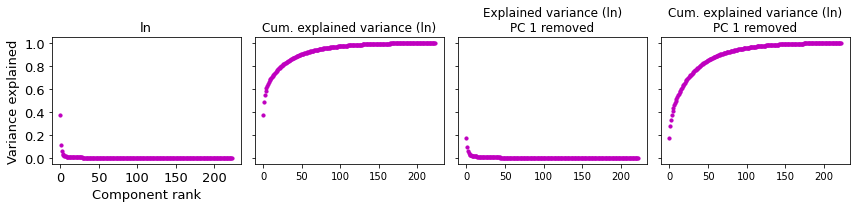

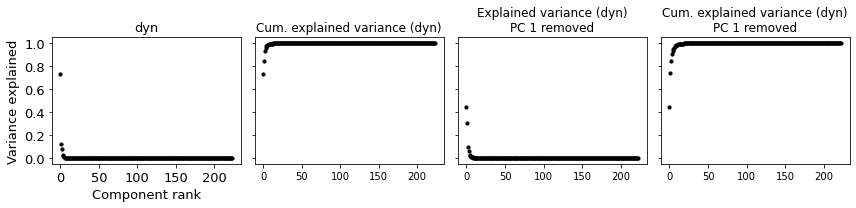

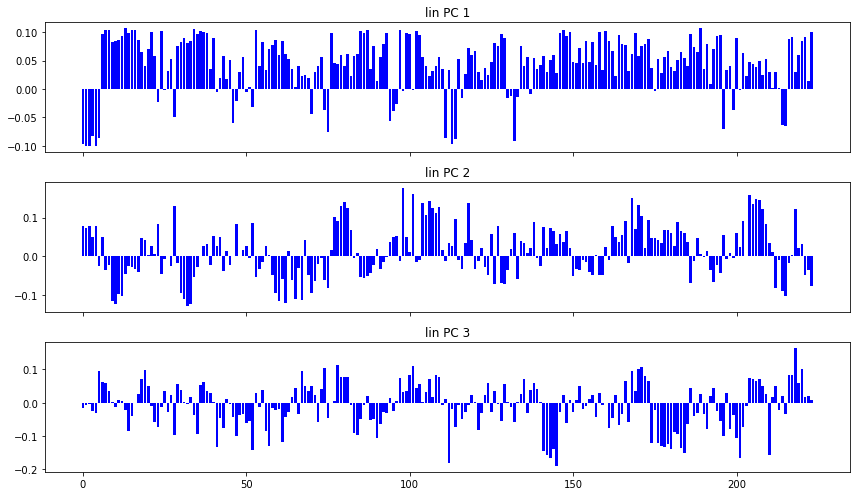

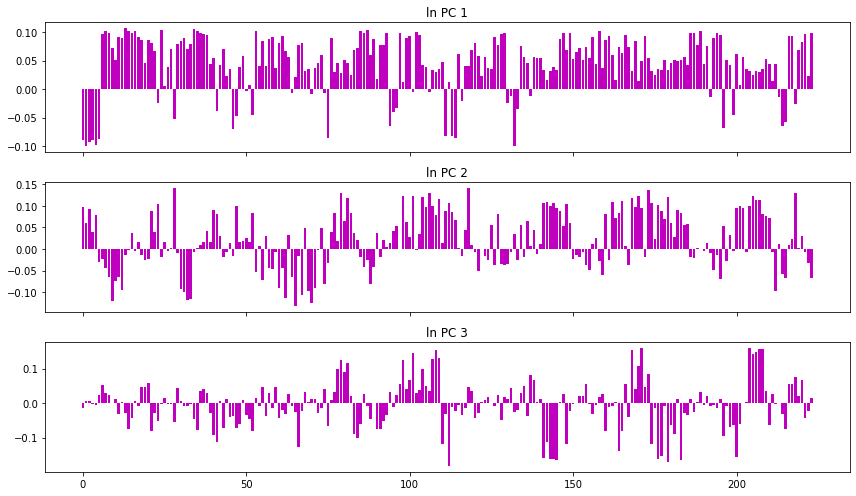

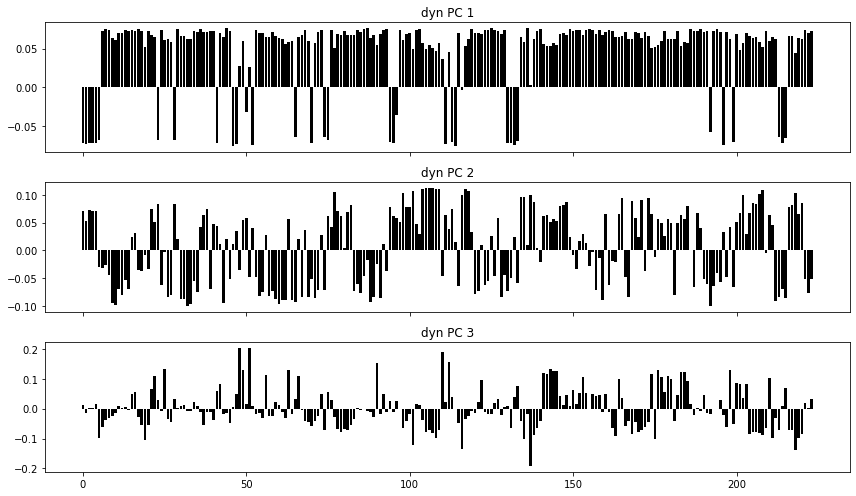

In [5]:
# plot PCA eigenspectra results for each nrl mdl
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True, sharey=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    expl_var = pca_rslt['expl_var']
    axs[0].scatter(np.arange(len(expl_var)), expl_var, s=10, c=color)
    set_plot(axs[0], x_label='Component rank', y_label='Variance explained', title=f'{nrl_mdl}', font_size=13)
    axs[1].scatter(np.arange(len(expl_var)), expl_var.cumsum(), s=10, c=color)
    axs[1].set_title(f'Cum. explained variance ({nrl_mdl})')
    
    expl_var_no_pc_1 = expl_var[1:]
    expl_var_no_pc_1 /= expl_var_no_pc_1.sum()
    
    axs[2].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1, s=10, c=color)
    axs[2].set_title(f'Explained variance ({nrl_mdl})\nPC 1 removed')
    axs[3].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1.cumsum(), s=10, c=color)
    axs[3].set_title(f'Cum. explained variance ({nrl_mdl})\nPC 1 removed')
    
    fig.savefig(f'{nrl_mdl}_pca_var_expl.svg')
    
# plot top PCs for each nrl mdl
top_pcs = {}
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(3, 1, figsize=(12, 7), tight_layout=True, sharex=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    
    for cpc, ax in enumerate(axs):
        ax.bar(np.arange(NR), pca_rslt['pcs'][cpc, :], color=color)
        ax.set_title(f'{nrl_mdl} PC {cpc+1}')
    
    top_pcs[nrl_mdl] = pca_rslt['pcs'][:4, :]

# Project example song responses onto PCs of different models

In [6]:
from disp import trj_2d

In [7]:
DF_LIN_PARAM = pd.read_csv('data/simple/neur/baker_lin_fit_param.csv')
DF_LN_PARAM = pd.read_csv('data/simple/neur/baker_ln_fit_param.csv')
DF_DYN_PARAM = pd.read_csv('data/simple/neur/baker_dyn_fit_param.csv')

FPS_DN = 8.5  # sampling rate from neural data
DT_DN = 1/FPS_DN
NT_H_DN = 85
T_H_DN = np.arange(NT_H_DN)*DT_DN

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS
NT_H = int(round(NT_H_DN*FPS/FPS_DN))
T_H = np.arange(NT_H)*DT

H_S_COLS = [f'IT_H_S_{it}' for it in range(NT_H_DN)]
H_P_COLS = [f'IT_H_P_{it}' for it in range(NT_H_DN)]

EXPT_IDS = DF_LIN_PARAM['EXPT_ID']

In [8]:
# linear simulation
# filters (downsampled)
hs_lin_dn_s = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_lin_dn_p = np.array([DF_LIN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_lin_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_s])[:-1]) for h_lin_dn_s in hs_lin_dn_s])
hs_lin_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_lin_dn_p])[:-1]) for h_lin_dn_p in hs_lin_dn_p])

def smlt_lin_(i_s, i_p, h_s, h_p):
    """Single neuron"""
    r = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] \
        + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    return r


def smlt_lin(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p) in enumerate(zip(hs_lin_s, hs_lin_p)):
        rs[:, cr] = smlt_lin_(i_s, i_p, h_s, h_p)
        
    return rs


# linear-nonlinear simulation
# filters (downsampled)
hs_ln_dn_s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_S_COLS] for expt_id in EXPT_IDS]).astype(float)
hs_ln_dn_p = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0][H_P_COLS] for expt_id in EXPT_IDS]).astype(float)

# upsample filters via interpolation
hs_ln_s = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_s])[:-1]) for h_ln_dn_s in hs_ln_dn_s])
hs_ln_p = np.array([np.interp(T_H, T_H_DN, cc([[0], h_ln_dn_p])[:-1]) for h_ln_dn_p in hs_ln_dn_p])

r_mins = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MIN'] for expt_id in EXPT_IDS])
r_maxs = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['R_MAX'] for expt_id in EXPT_IDS])
z_0s = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['Z_0'] for expt_id in EXPT_IDS])
betas = np.array([DF_LN_PARAM[EXPT_IDS == expt_id].iloc[0]['BETA'] for expt_id in EXPT_IDS])

def smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta):
    """Single neuron."""
    z = DT*(signal.fftconvolve(i_s, h_s, mode='full')[:len(i_s)] + signal.fftconvolve(i_p, h_p, mode='full')[:len(i_p)])
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


def smlt_ln(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (h_s, h_p, r_min, r_max, z_0, beta) in enumerate(zip(hs_ln_s, hs_ln_p, r_mins, r_maxs, z_0s, betas)):
        rs[:, cr] = smlt_ln_(i_s, i_p, h_s, h_p, r_min, r_max, z_0, beta)
        
    return rs


# nonlinear adaptive simulation
tau_rs = np.array(DF_DYN_PARAM['TAU_R'])
tau_as = np.array(DF_DYN_PARAM['TAU_A'])
x_ss = np.array(DF_DYN_PARAM['X_S'])
x_ps = np.array(DF_DYN_PARAM['X_P'])

def smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    t = np.arange(len(i_s))*DT
    r = np.nan*np.zeros(len(t))
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

def smlt_dyn(sng):
    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)
    
    rs = np.nan * np.zeros((len(sng), len(EXPT_IDS)))
    
    for cr, (tau_r, tau_a, x_s, x_p) in enumerate(zip(tau_rs, tau_as, x_ss, x_ps)):
        rs[:, cr] = smlt_dyn_(i_s, i_p, tau_r, tau_a, x_s, x_p)
        
    return rs

In [9]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

    
from disp import plot_b
colors_1 = ['gray', 'b', 'r']
colors_2 = ['gray', 'dodgerblue', 'salmon']

def plt_rsps(sng, rsp, x_pc, y_pc, pcs):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3.5), tight_layout=True, sharex=True, sharey=True)
    colors = colors_1
    t = np.arange(len(sng))*DT
    plot_b(axs[0], t, sng, [0, t.max()+DT, 0, 2], c=colors_1)
        
    r_lin = rsp['lin'] @ pcs['lin'].T
    r_ln = rsp['ln'] @ pcs['ln'].T
    r_dyn = rsp['dyn'] @ pcs['dyn'].T

    trj_2d(axs[1], t, r_lin[:, x_pc], r_lin[:, y_pc], sng, c=colors, s_max=50)
    trj_2d(axs[2], t, r_ln[:, x_pc], r_ln[:, y_pc], sng, c=colors, s_max=50)
    trj_2d(axs[3], t, r_dyn[:, x_pc], r_dyn[:, y_pc], sng, c=colors, s_max=50)
        
    axs[1].set_title('LIN response')
    axs[2].set_title('LN response')
    axs[3].set_title('DYN response')
    
    axs[0].set_xlabel('Time (s)')
    for ax in axs[1:]:
        ax.scatter([0], [0], marker='^', c='k')
        set_plot(ax, x_label=f'PC {x_pc+1}', y_label=f'PC {y_pc+1}')

In [10]:
sngs = [
    make_sng(10, s=[(0, 10)]),
    make_sng(10, p=[(0, 10)]),
    make_sng(10, s=[(0, 5)], p=[(5, 10)]),
    make_sng(10, s=[(5, 10)], p=[(0, 5)]),
    make_sng(10, s=[(0, 2)], p=[(2, 10)]),
    make_sng(10, s=[(8, 10)], p=[(0, 8)]),
    make_sng(10, s=[(2, 10)], p=[(0, 2)]),
    make_sng(10, s=[(0, 8)], p=[(8, 10)]),
    make_sng(4, s=[(0, .5), (1, 1.5), (2, 2.5), (3, 3.5)], p=[(.5, 1), (1.5, 2), (2.5, 3), (3.5, 4)]),
    make_sng(4, p=[(0, .5), (1, 1.5), (2, 2.5), (3, 3.5)], s=[(.5, 1), (1.5, 2), (2.5, 3), (3.5, 4)]),
    make_sng(4,
        s=[(0, .25), (.5, .75), (1, 1.25), (1.5, 1.75), (2, 2.25), (2.5, 2.75), (3, 3.25), (3.5, 3.75)],
        p=[(.25, .5), (.75, 1.), (1.25, 1.5), (1.75, 2), (2.25, 2.5), (2.75, 3), (3.25, 3.5), (3.75, 4)]),
    make_sng(4,
        p=[(0, .25), (.5, .75), (1, 1.25), (1.5, 1.75), (2, 2.25), (2.5, 2.75), (3, 3.25), (3.5, 3.75)],
        s=[(.25, .5), (.75, 1.), (1.25, 1.5), (1.75, 2), (2.25, 2.5), (2.75, 3), (3.25, 3.5), (3.75, 4)]),
]

In [11]:
# compute responses of different neural models
rsps = []

for sng in sngs:
    r_lin = smlt_lin(sng)
    r_ln = smlt_ln(sng)
    r_dyn = smlt_dyn(sng)
    rsps.append({'lin': r_lin, 'ln': r_ln, 'dyn': r_dyn})

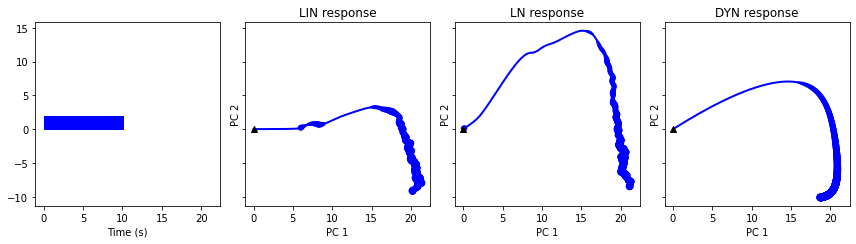

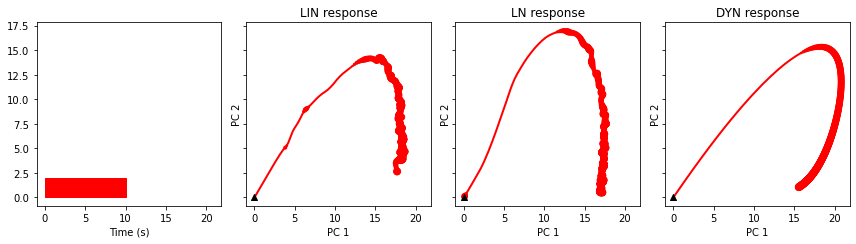

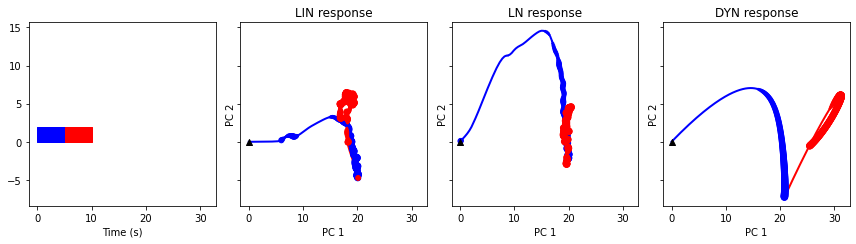

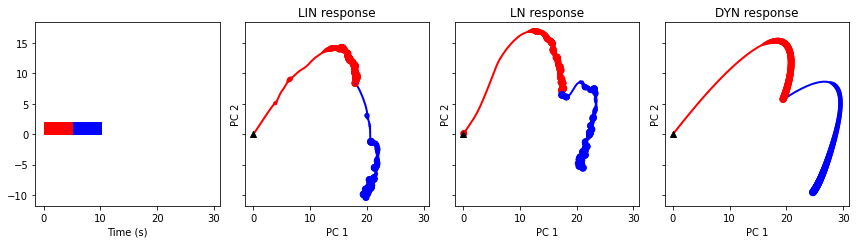

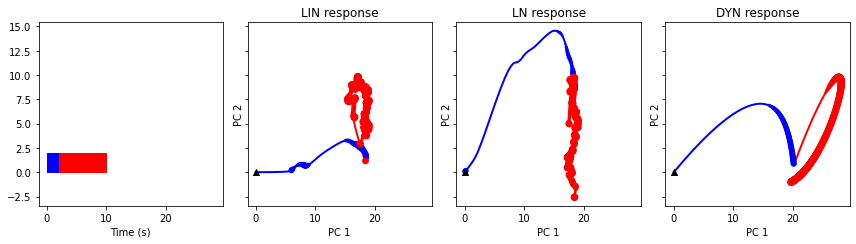

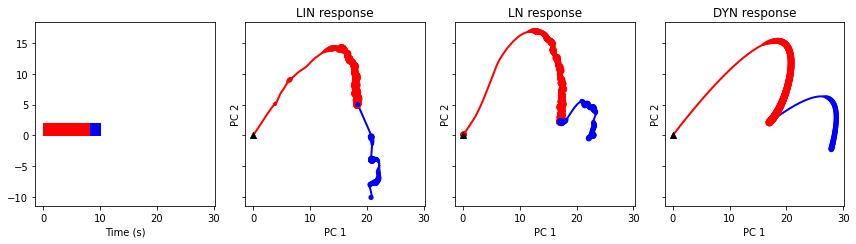

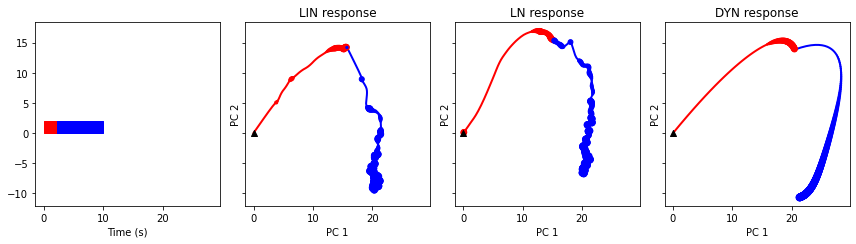

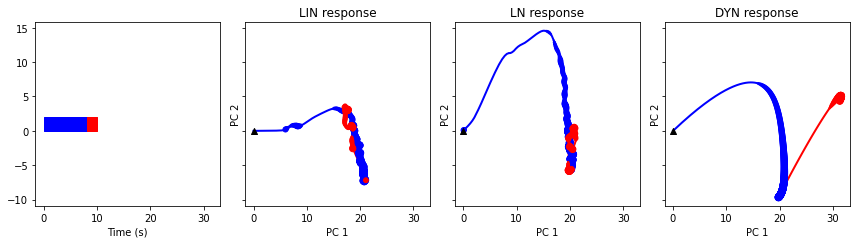

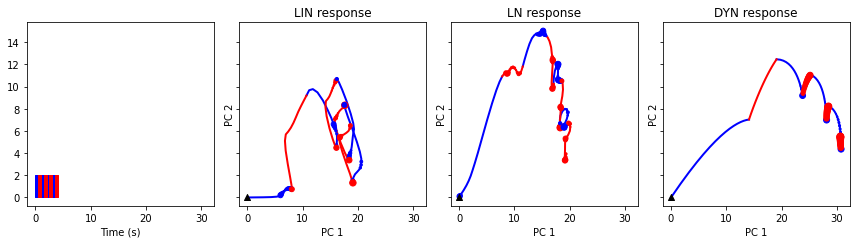

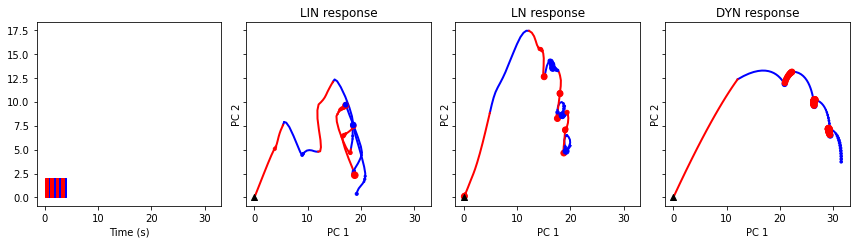

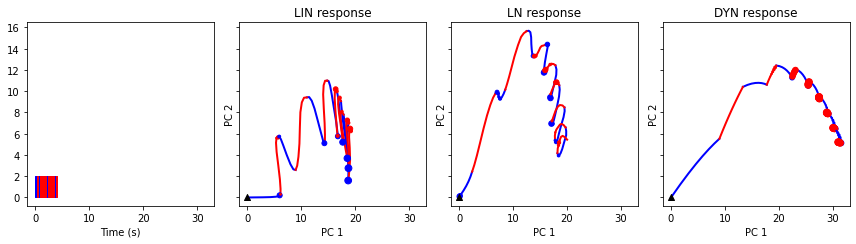

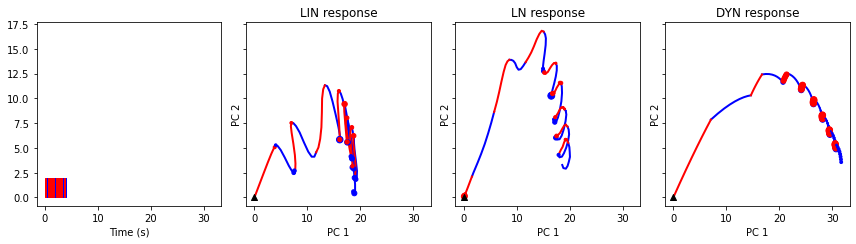

In [12]:
for sng, rsp in zip(sngs, rsps):
    plt_rsps(sng, rsp, x_pc=0, y_pc=1, pcs=top_pcs)

In [13]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]

(100.0, 160.0)

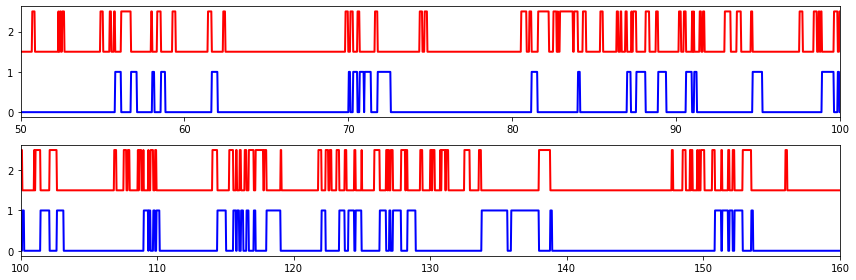

In [14]:
df_tr = df_song[df_song['ID'] == 0]
q = np.array(df_tr['Q'])
s = np.array(df_tr['S'])
p = np.array(df_tr['P'] | df_tr['F'])

fig, axs = plt.subplots(2, 1, figsize=(12, 4), tight_layout=True)
for ax in axs:
    ax.plot(df_tr['T'], s, lw=2, c='b')
    ax.plot(df_tr['T'], p+1.5, lw=2, c='r')
    
axs[0].set_xlim(50, 100)
axs[1].set_xlim(100, 160)

In [15]:
wdws = [(50, 55), (69, 74), (80, 85), (122, 127), (148, 153), (138, 143), (107, 112)]

In [16]:
sngs = []

for wdw in wdws:
    mt = (wdw[0] <= df_tr['T']) & (df_tr['T'] < wdw[1])
    t = np.arange(mt.sum())*DT
    sng = np.zeros(len(t))
    sng[s[mt] == 1] = 1
    sng[p[mt] == 1] = 2
    sngs.append(sng.astype(int))

In [17]:
# compute responses of different neural models
rsps = []
for sng in sngs:
    r_lin = smlt_lin(sng)
    r_ln = smlt_ln(sng)
    r_dyn = smlt_dyn(sng)
    rsps.append({'lin': r_lin, 'ln': r_ln, 'dyn': r_dyn})

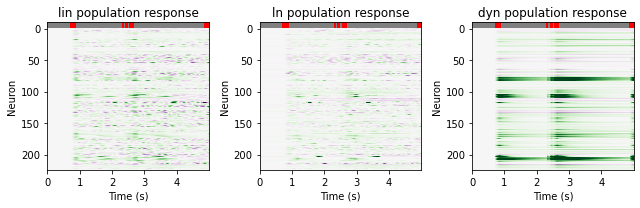

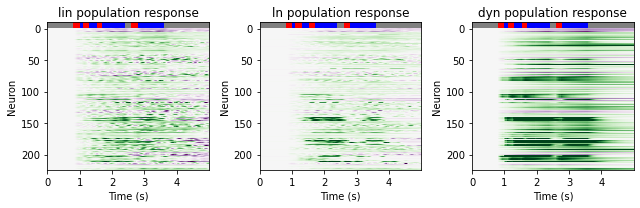

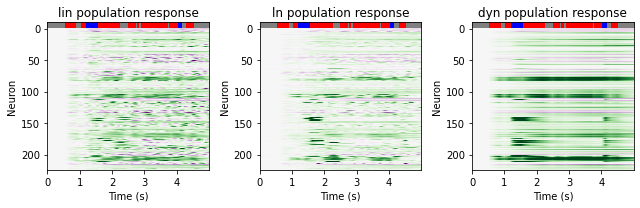

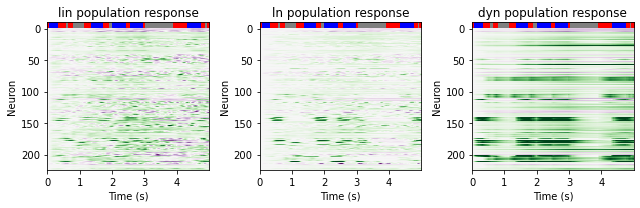

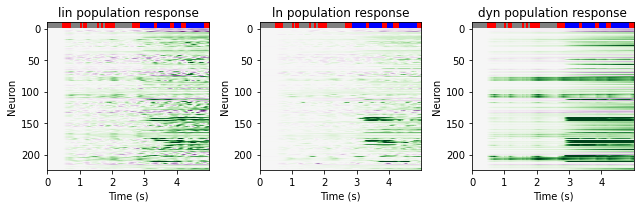

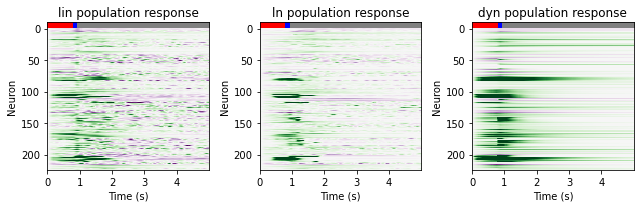

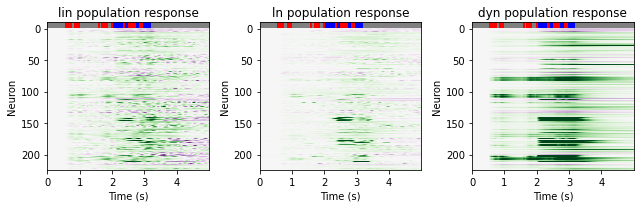

In [18]:
for sng, rsp in zip(sngs, rsps):
    fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
    
    for nrl_mdl, ax in zip(NRL_MDLS, axs):
        v_min = rsp[nrl_mdl].min()
        v_max = rsp[nrl_mdl].max()

        if v_min < -v_max:
            v_min = -v_max
        else:
            v_max = -v_min
            
        ax.matshow(rsp[nrl_mdl].T, vmin=v_min, vmax=v_max, cmap='PRGn', extent=[0, len(sng)*DT, rsp[nrl_mdl].shape[1], 0])
        plot_b(ax, np.arange(len(sng))*DT, sng, [0, t.max()+DT, -10, -2], c=['gray', 'b', 'r'])
        ax.set_aspect('auto')
        ax.set_ylim(top=-10)
        ax.xaxis.tick_bottom()
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Neuron')
        ax.set_title(f'{nrl_mdl} population response')

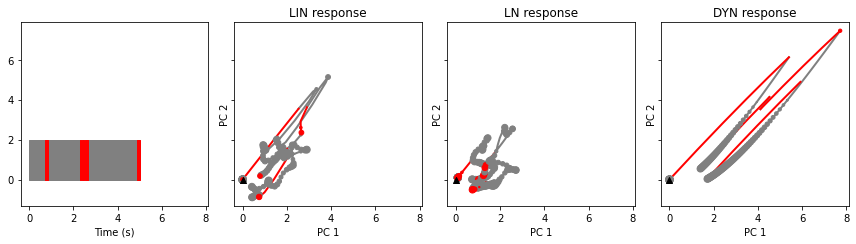

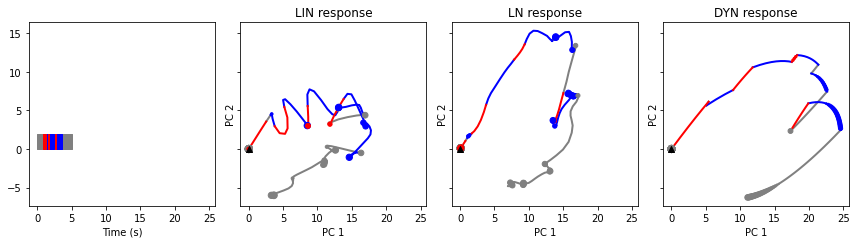

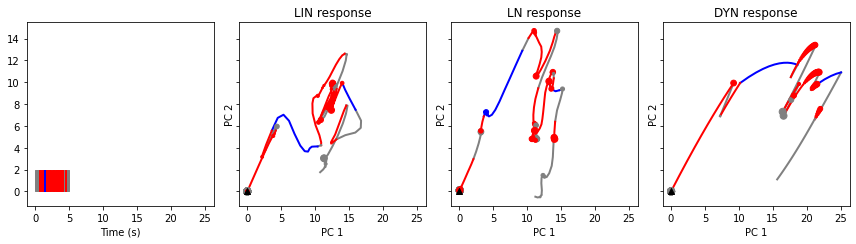

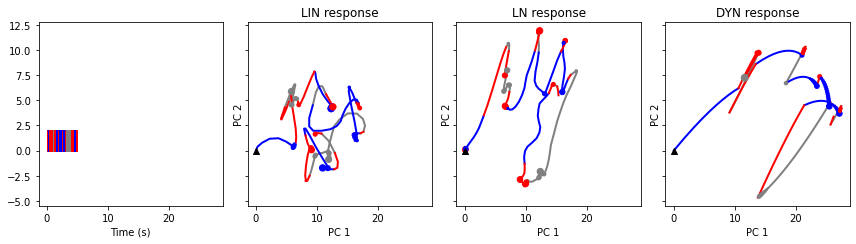

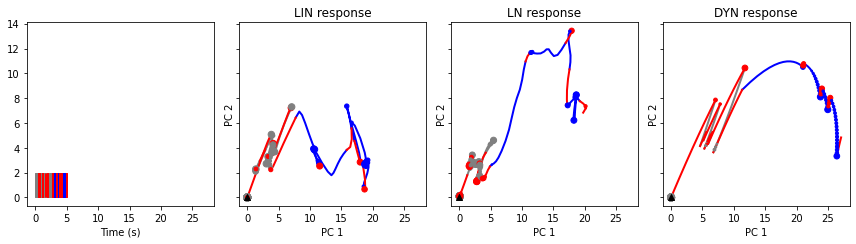

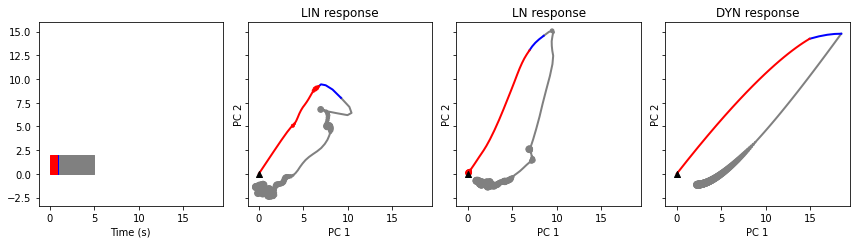

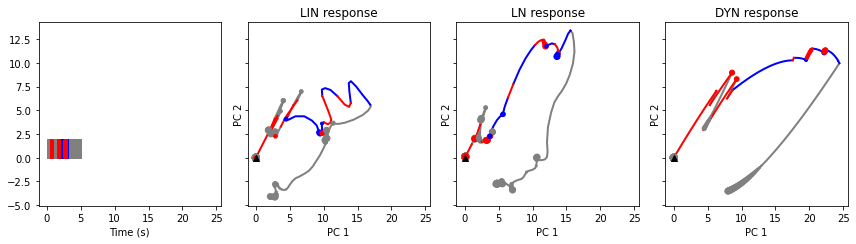

In [19]:
for sng, rsp in zip(sngs, rsps):
    plt_rsps(sng, rsp, x_pc=0, y_pc=1, pcs=top_pcs)

# Alt models

In [3]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal

from aux import zscore
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

NRL_DIRS = ['neur_basic', 'neur_basic', 'dyn_alt']
NRL_MDLS = ['ln', 'dyn', 'dyn_nonadapt']
COLORS = ['b', 'm', 'k']
FPCAS = [
    f'data/simple/mlv/{nrl_dir}/baker_{nrl_mdl}_pca_nm91_zh23/pca_results.npy'
    for nrl_dir, nrl_mdl in zip(NRL_DIRS, NRL_MDLS)
]

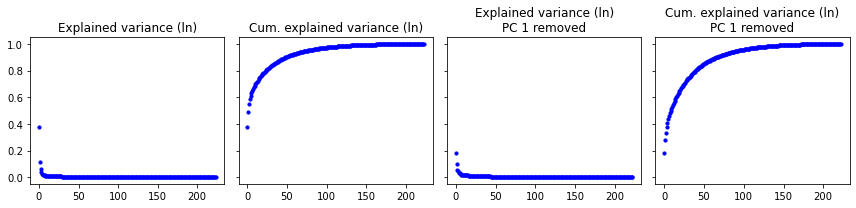

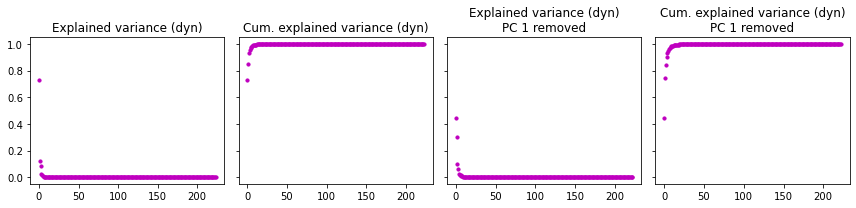

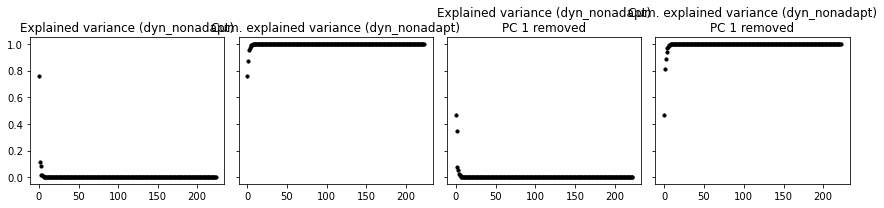

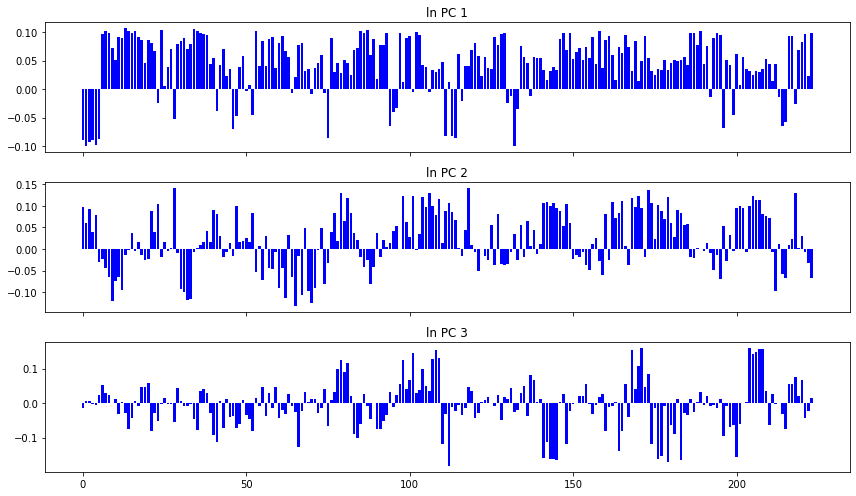

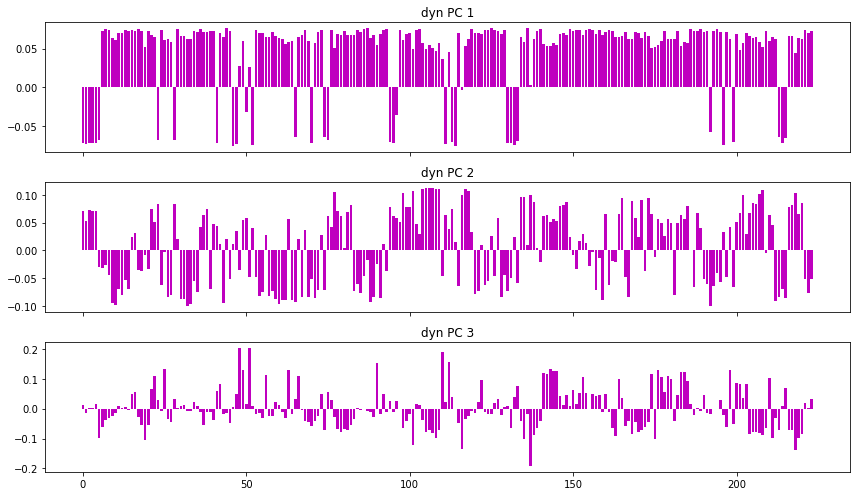

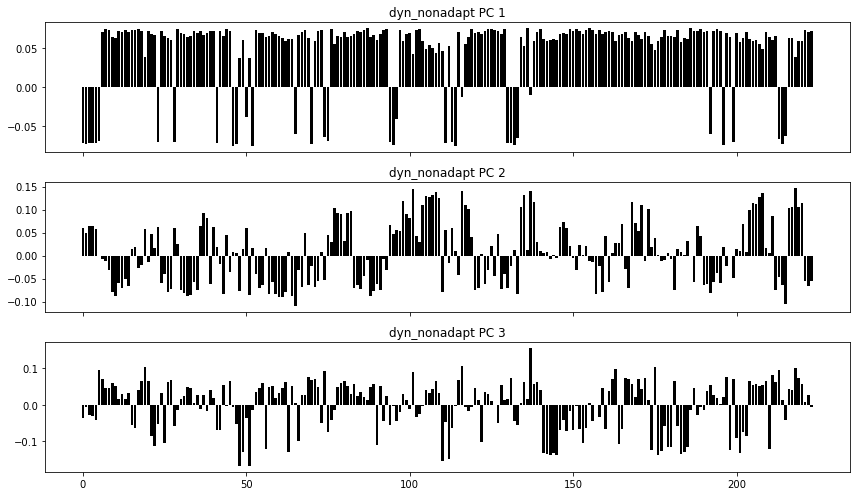

In [4]:
# plot PCA eigenspectra results for each nrl mdl
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True, sharey=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    expl_var = pca_rslt['expl_var']
    axs[0].scatter(np.arange(len(expl_var)), expl_var, s=10, c=color)
    axs[0].set_title(f'Explained variance ({nrl_mdl})')
    axs[1].scatter(np.arange(len(expl_var)), expl_var.cumsum(), s=10, c=color)
    axs[1].set_title(f'Cum. explained variance ({nrl_mdl})')
    
    expl_var_no_pc_1 = expl_var[1:]
    expl_var_no_pc_1 /= expl_var_no_pc_1.sum()
    
    axs[2].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1, s=10, c=color)
    axs[2].set_title(f'Explained variance ({nrl_mdl})\nPC 1 removed')
    axs[3].scatter(np.arange(len(expl_var_no_pc_1)), expl_var_no_pc_1.cumsum(), s=10, c=color)
    axs[3].set_title(f'Cum. explained variance ({nrl_mdl})\nPC 1 removed')
    
# plot top PCs for each nrl mdl
top_pcs = {}
for nrl_mdl, color, fpca in zip(NRL_MDLS, COLORS, FPCAS):
    fig, axs = plt.subplots(3, 1, figsize=(12, 7), tight_layout=True, sharex=True)
    pca_rslt = np.load(fpca, allow_pickle=True)[0]
    
    for cpc, ax in enumerate(axs):
        ax.bar(np.arange(NR), pca_rslt['pcs'][cpc, :], color=color)
        ax.set_title(f'{nrl_mdl} PC {cpc+1}')
    
    top_pcs[nrl_mdl] = pca_rslt['pcs'][:4, :]